In [104]:
import numpy as np
import recurrence as rec
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform, cdist
from scipy.integrate import solve_ivp
import pandas as pd

In [39]:
#Recurrence matrix updated version
def recurrence_matrix(timeseries, epsilon, transpose = False):

    if timeseries.ndim == 1:
        r_matrix = []
        for i in range(len(timeseries)):
            current_row = []
            for j in range(len(timeseries)):
                current_value = np.abs(timeseries[i] - timeseries[j])
                if current_value <= epsilon:
                    current_row.append(1)
                else:
                    current_row.append(0)
        
            r_matrix.append(current_row)
    
        return np.array(r_matrix)
    
    else: 
        '''
        We will use euclidean distance in order to estimate neighbours.
        '''
        #Create distance matrix
        if transpose == True:
            timeseries = timeseries.T

        d_matrix = squareform(pdist(timeseries, metric = 'euclidean'))

        return d_matrix <= epsilon
    
#Find epsilon
def optimal_epsilon(timeseries, rrate, transpose = False):
    #1-dimensional time series
    if timeseries.ndim == 1:
        d_matrix = []
        for i in range(len(timeseries)):
            current_row = []
            for j in range(len(timeseries)):
                current_value = np.abs(timeseries[i] - timeseries[j])
                current_row.append(current_value)  
            d_matrix.append(current_row)
    
        d_matrix = np.array(d_matrix)

    # N-dimensional time series (N>1)
    else:
        #Create distance matrix
        if transpose == True:
            timeseries = timeseries.T

        d_matrix = squareform(pdist(timeseries, metric = 'euclidean'))
    #Colapse distance matrices and sort its values
    d_vector = d_matrix.flatten()

    #Sort values
    d_vector= np.sort(d_vector)

    n = int(len(d_vector)*rrate)

    return d_vector[n]

In [48]:
#Mutually coupled Roessler systems
#taken from Marwan (2007), eqs. A.9 and A.10
def coupled_Roessler(t, X, a, b, c, nu, mu):
    """
    X is a flattened vector [x1, x2, x3, y1, y2, y3].
    x corresponds to the first system, y corresponds to the 
    second one. 
    """
    dX = np.zeros(len(X))

    #First system (A.9)
    dX[0] = -(1 + nu)*X[1] - X[2]
    dX[1] = (1 + nu)*X[0] + a*X[1] + mu*(X[4] - X[1])
    dX[2] = b + X[2]*(X[0] - c)

    #Second system (A.10)
    dX[3] = -(1 - nu)*X[4] - X[5]
    dX[4] = (1 - nu)*X[3] + a*X[4] + mu*(X[1] - X[4])
    dX[5] = b + X[5]*(X[3] - c)

    return dX

In [83]:
# Parametres phase coherent regime
# Marwan (2007, p. 290)


a, b, c = 0.16, 0.1, 8.5
nu = 0.02
mu = 0.05


"""
a, b, c = 0.2925, 0.1, 8.5
nu = 0.02
mu = 0.2
"""

#Timestep and length not specified in paper
"""
1000 time steps was to short to show behaviour. We let it stabilize
for 5000 timesteps and use the remaining 10000
"""
T = 15000*0.02  #
dt = 0.02 #Bigger dt gave too rough of a plot

In [84]:
# Numerically Integrate The System States
#Initial conditions not specified
X0 = [0,0,0,0,0,0]

t_span = (0, T)
t_eval = np.arange(0, T, dt)

sol = solve_ivp(coupled_Roessler, t_span, X0, t_eval=t_eval, args=(a, b, c, nu, mu), method="RK45")

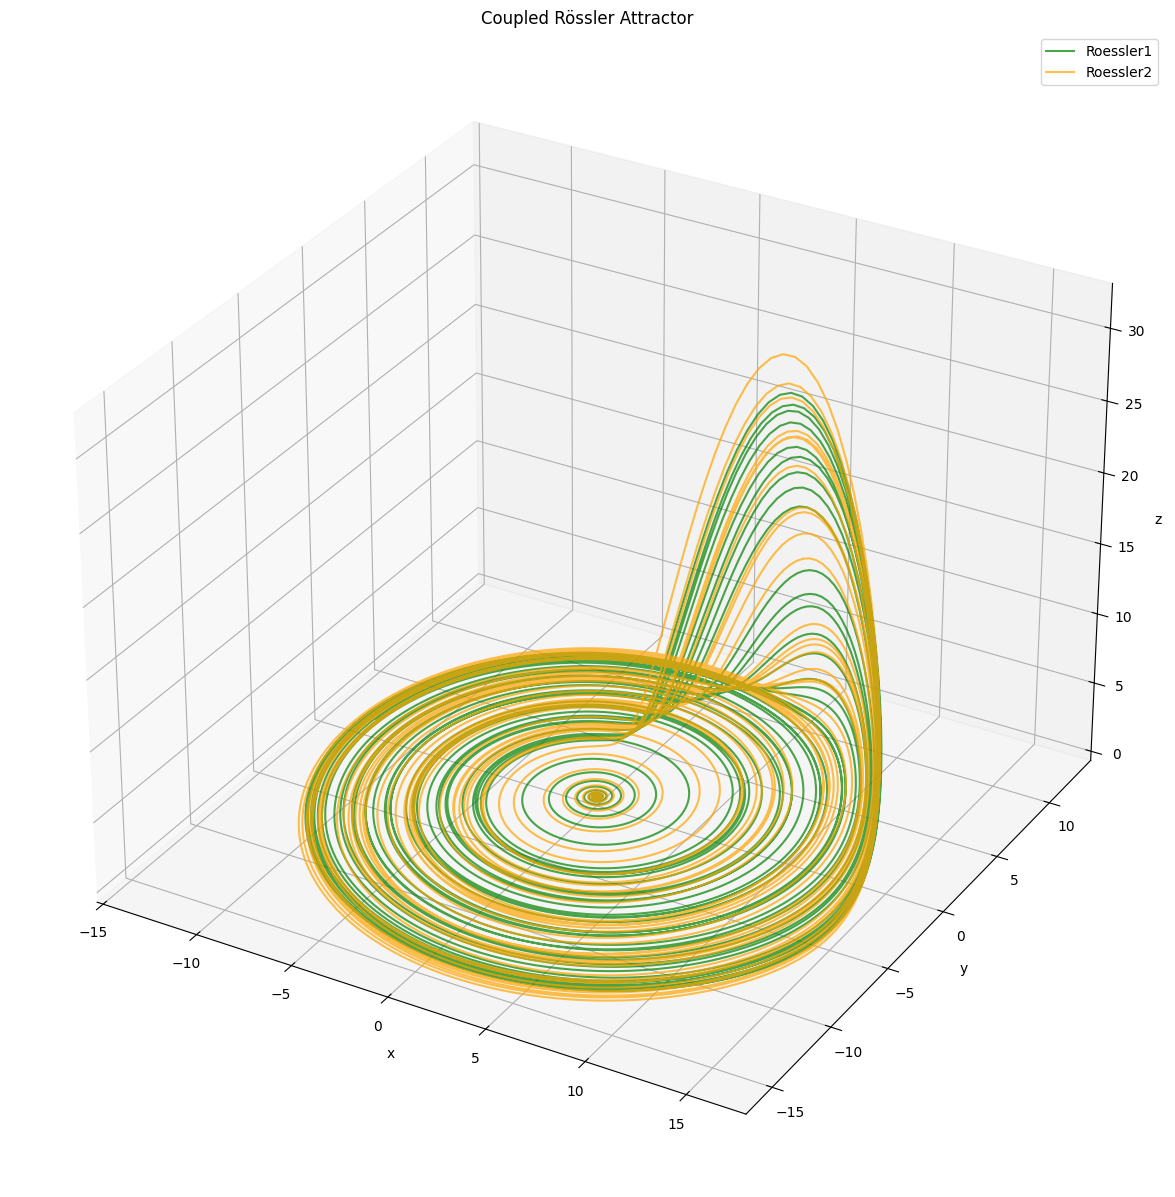

In [85]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

ax.plot(sol.y[0], sol.y[1], sol.y[2], alpha=0.7, label = 'Roessler1', color = 'green')
ax.plot(sol.y[3], sol.y[4], sol.y[5], alpha=0.7, label = 'Roessler2', color = 'orange')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.legend()
ax.set_title(f"Coupled Rössler Attractor")

plt.show()

In [90]:
#Separate models
R1_ts = sol.y[:3].T
R2_ts = sol.y[3:].T

#Get model after 5000 time steps
R1_ts = R1_ts[5000:]
R2_ts = R2_ts[5000:]

We check PS with recurrence plots using a recurrence rate of 0.06.

In [91]:
eps_1 = optimal_epsilon(R1_ts,0.06)
eps_2 = optimal_epsilon(R2_ts,0.06)

In [94]:
rec_1 = recurrence_matrix(R1_ts,eps_1)
rec_2 = recurrence_matrix(R2_ts,eps_2)

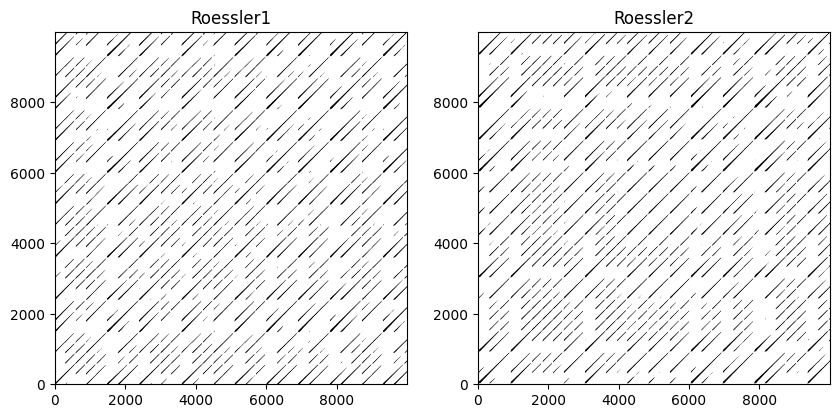

In [95]:
#Visualize
fig, axs = plt.subplots(1,2,figsize=(10, 10))

#Plot
axs[0].imshow(rec_1, origin='lower', cmap = 'binary')
axs[0].set_title('Roessler1')

axs[1].imshow(rec_2, origin='lower', cmap = 'binary')
axs[1].set_title('Roessler2')


plt.show()

Check $RR_{\tau}$ just to be sure

In [96]:
tau_rr_1 = rec.tau_recurrence(rec_1)
tau_rr_2 = rec.tau_recurrence(rec_2)

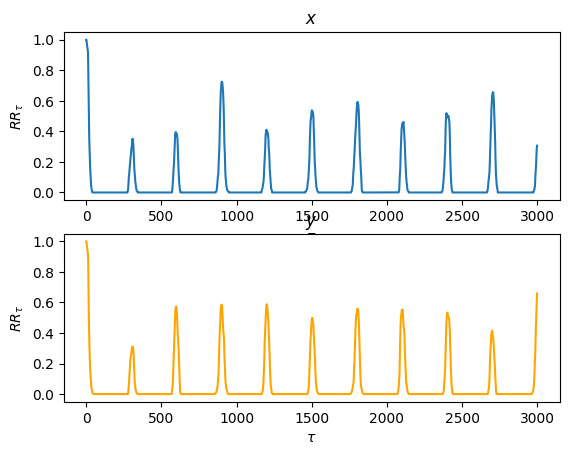

In [102]:
fig, ax = plt.subplots(2,1)   


ax[0].plot(np.arange(0,3000,1),tau_rr_1[:3000])
ax[0].set_title(r'$x$')
ax[0].set_ylabel(r'$RR_{\tau}$')
ax[0].set_xlabel(r'$\tau$')
ax[1].plot(np.arange(0,3000,1),tau_rr_2[:3000], color = 'orange')
ax[1].set_title(r'$y$')
ax[1].set_ylabel(r'$RR_{\tau}$')
ax[1].set_xlabel(r'$\tau$')

plt.show() 

In [103]:
print(rec.cpr(rec_1,rec_2))

0.7898373130255639


They are in PS :)

Let's save it then.

In [105]:
# convert arrays into dataframe
DF1 = pd.DataFrame(R1_ts)
DF2 = pd.DataFrame(R2_ts)

# save the dataframe as a csv file
DF1.to_csv("PS_Roessler1.csv")
DF2.to_csv("PS_Roessler2.csv")